In [1]:
# cài đặt thư viện d2l
!pip install d2l==0.16.5

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.4 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.4 MB/s eta 0:00:00
  Attempting 

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [21]:
for i, data in enumerate(train_iter):
  print(data)
  break

(tensor([[ 9,  1, 18,  ...,  1,  8,  7],
        [ 3,  9,  4,  ...,  4,  8,  8],
        [ 6, 18,  2,  ...,  1,  9,  5],
        ...,
        [12,  1, 14,  ...,  6,  1,  4],
        [ 1,  3, 10,  ...,  2,  1,  4],
        [ 9,  2,  1,  ..., 10,  2, 17]]), tensor([[ 1, 18,  1,  ...,  8,  7,  1],
        [ 9,  4,  3,  ...,  8,  8,  2],
        [18,  2, 10,  ...,  9,  5,  8],
        ...,
        [ 1, 14,  8,  ...,  1,  4,  3],
        [ 3, 10,  4,  ...,  1,  4,  6],
        [ 2,  1, 20,  ...,  2, 17,  1]]))


In [3]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    def three():
        return (normal(
            (num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # Update gate parameters
    W_xr, W_hr, b_r = three()  # Reset gate parameters
    W_xh, W_hh, b_h = three()  # Candidate hidden state parameters
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [4]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

In [5]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        # Compute update gate Z
        Z = torch.sigmoid(torch.matmul(X, W_xz) + torch.matmul(H, W_hz) + b_z)

        # Compute reset gate R
        R = torch.sigmoid(torch.matmul(X, W_xr) + torch.matmul(H, W_hr) + b_r)

        # Compute candidate hidden state H_tilda
        H_tilda = torch.tanh(torch.matmul(X, W_xh) + torch.matmul(R * H, W_hh) + b_h)

        # Compute the new hidden state H
        H = Z * H + (1 - Z) * H_tilda

        # Compute the output Y (which is often the linear transformation of the hidden state)
        Y = torch.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

perplexity 1.3, 33629.2 tokens/sec on cuda:0
time traveller the psychologistyou can move about in all in and 
traveller his four dimensionedbeing which is a fixed and an


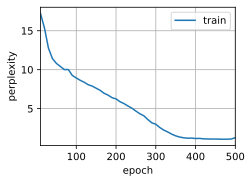

In [6]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 1.0, 289750.8 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


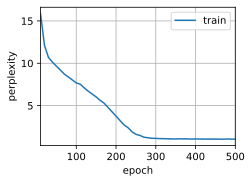

In [7]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model_gru = d2l.RNNModel(gru_layer, len(vocab))
model_gru = model_gru.to(device)
d2l.train_ch8(model_gru, train_iter, vocab, lr, num_epochs, device)

perplexity 1.3, 427308.9 tokens/sec on cuda:0
time travellerit s against reasonablear said the medical man the
travelleryou can shared ascelon to the ell inouderad in a c


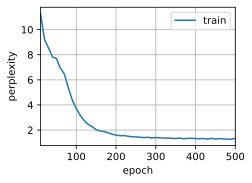

In [8]:
#RNN model
num_inputs = vocab_size
rnn_layer = nn.RNN(vocab_size, num_hiddens)
model_rnn = d2l.RNNModel(rnn_layer, vocab_size)
model_rnn = model_rnn.to(device)
d2l.train_ch8(model_rnn, train_iter, vocab, lr, num_epochs, device)

perplexity 1.3, 427975.6 tokens/sec on cuda:0
time traveller for so it wild the way he supo poung mat ave alli
traveller for ang have lot said the psychologist looked at 
RNN training time: 24.08 seconds


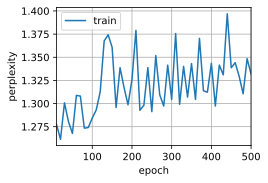

In [10]:
# Compare Time
import time

# Measure training time for RNN
start = time.time()
d2l.train_ch8(model_rnn, train_iter, vocab, lr, num_epochs, device)
end = time.time()
print(f'RNN training time: {end - start:.2f} seconds')

perplexity 1.0, 300602.0 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby
GRU training time: 26.62 seconds


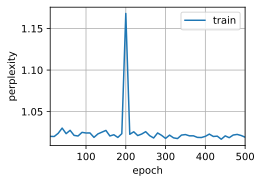

In [11]:
# Measure training time for GRU
start = time.time()
d2l.train_ch8(model_gru, train_iter, vocab, lr, num_epochs, device)
end = time.time()
print(f'GRU training time: {end - start:.2f} seconds')

In [18]:
def predict(prefix, num_preds, model, vocab, device):
    state = model.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:
        _, state = model(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):
        y, state = model(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

# Generate sequences for comparison
print("RNN output:", predict('newtral network', 40, model_rnn, vocab, device))
print("GRU output:", predict('newtral network', 40, model_gru, vocab, device))

RNN output: newtral networkick su nee thing to expect us to begin u
GRU output: newtral networkove tome praceecer trey tran itslass of 


Conclusion
- GRU and RNN often take simimar time for running
- Perplexity of GRU is much better than RNN